
============= 학습 시작 =============
epochs: 0; loss: 2.302459; accuracy: 0.123000
epochs: 1; loss: 2.302438; accuracy: 0.128000
epochs: 2; loss: 2.302416; accuracy: 0.133000
epochs: 3; loss: 2.302395; accuracy: 0.140000
epochs: 4; loss: 2.302374; accuracy: 0.151000
epochs: 5; loss: 2.302352; accuracy: 0.155000
epochs: 6; loss: 2.302330; accuracy: 0.158000
epochs: 7; loss: 2.302309; accuracy: 0.167000
epochs: 8; loss: 2.302288; accuracy: 0.174000
epochs: 9; loss: 2.302266; accuracy: 0.188000
epochs: 10; loss: 2.302244; accuracy: 0.200000
epochs: 11; loss: 2.302223; accuracy: 0.208000
epochs: 12; loss: 2.302201; accuracy: 0.216000
epochs: 13; loss: 2.302179; accuracy: 0.229000
epochs: 14; loss: 2.302157; accuracy: 0.240000
epochs: 15; loss: 2.302135; accuracy: 0.250000
epochs: 16; loss: 2.302112; accuracy: 0.256000
epochs: 17; loss: 2.302089; accuracy: 0.266000
epochs: 18; loss: 2.302066; accuracy: 0.276000
epochs: 19; loss: 2.302043; accuracy: 0.290000
epochs: 20; loss: 2.302019; accurac

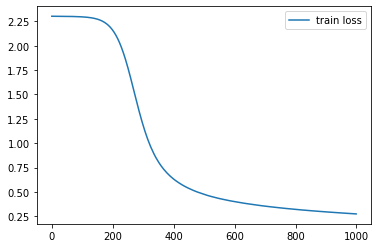

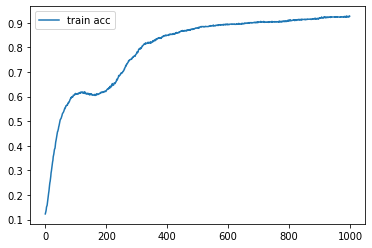

In [ ]:
from collections import OrderedDict
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
 
def softmax(a):
  if a.ndim == 2:
    a = a.T
    c = np.max(a, axis = 0)
    exp_a = np.exp(a - c) # 오버 플로우를 방지하기 위해 c를 빼준다.
    exp_a = exp_a / np.sum(exp_a, axis=0)
    return exp_a.T
 
  c = np.max(a)
  exp_a = np.exp(a - c)
  return exp_a / np.sum(exp_a)
 
def cross_entropy_error(x, t):
  return -np.sum(t * np.log(x)) / x.shape[0]
 
# affine transformation
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None
 
  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b
 
    return out
 
  def backward(self, dout):
    self.dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
     
    return self.dx
 
# 렐루 층
class Relu:
  def __init__(self):
    self.mask = None
 
  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
 
    return out
 
  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
 
    return dout
 
# 소프트맥스 함수와, 손실함수가 합쳐진 층
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None
 
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    return (self.y - self.t) / batch_size
 
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
 
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
 
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
 
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col
 
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
 
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
 
    return img[:, :, pad:H + pad, pad:W + pad]
 
# 합성곱 구현
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None
 
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
 
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
 
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
 
        self.x = x
        self.col = col
        self.col_W = col_W
 
        return out
 
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
 
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
 
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
 
        return dx
 
# 풀링 구현
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
 
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
 
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
 
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
 
        self.x = x
        self.arg_max = arg_max
 
        return out
 
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx
 
class Flatten:
  def __init__(self):
    self.N = None
    self.C = None
    self.H = None
    self.W = None
 
  def forward(self, x):
    self.N, self.C, self.H, self.W = x.shape
    out = x.reshape(self.N, -1)
    return out
  
  def backward(self, dout):
    dout_reshape = dout.reshape(self.N, self.C, self.H, self.W)
    return dout_reshape
    
class SimpleConvNet:
  def __init__(self, input_dim = (1, 28, 28),
               conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
               hidden_size=100,
               output_size=10,
               weight_init_std=0.01,
               lr=0.01,
               batch_size=300,
               epochs=100):
    filter_num = conv_param['filter_num']
    filter_size = conv_param['filter_size']
    filter_pad = conv_param['pad']
    filter_stride = conv_param['stride']
 
    input_size = input_dim[1]
    # 합성곱 계층의 출력 크기를 계산한다.
    conv_output_size = (input_size + 2*filter_pad - filter_size) / filter_stride + 1
    # 풀링 계층의 출력 크기를 먼저 계산한다.
    pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
 
    # 가중치 초기화
    self.params = {}
    self.params['W1'] = np.random.randn(filter_num, input_dim[0], filter_size, filter_size) * weight_init_std
    self.params['b1'] = np.zeros(filter_num)
    self.params['W2'] = np.random.randn(pool_output_size, hidden_size) * weight_init_std
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size)
 
    # 신경망 층 구축
    self.layers = OrderedDict()
    self.layers['Conv1'] = Convolution(self.params['W1'], 
                                       self.params['b1'], 
                                       conv_param['stride'], 
                                       conv_param['pad'])
    self.layers['Relu1'] = Relu()
    self.layers['pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
    self.layers['flatten'] = Flatten()
    self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
    self.layers['Relu2'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
    self.last_layer = SoftmaxWithLoss()
 
    # 하이퍼 파라미터
    self.lr = lr
    self.batch_size = batch_size
    self.epochs = epochs
 
  def predict(self, x):
    for name, layer in self.layers.items():
      x = layer.forward(x)
    return x
 
  def loss(self, x, t):
    y = self.predict(x)
    return self.last_layer.forward(y, t)
 
  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    return np.mean(y == np.argmax(t, axis=1)).astype('float')
 
  def gradient(self, x, t):
    self.loss(x, t)
 
    dout = 1
    dout = self.last_layer.backward(dout)
 
    layers = list(self.layers.values())
    layers.reverse()
 
    for layer in layers:
      dout = layer.backward(dout)
 
    grads = {}
    grads['W1'] = self.layers['Conv1'].dW
    grads['b1'] = self.layers['Conv1'].db
    grads['W2'] = self.layers['Affine1'].dW
    grads['b2'] = self.layers['Affine1'].db
    grads['W3'] = self.layers['Affine2'].dW
    grads['b3'] = self.layers['Affine2'].db
 
    return grads
 
  def generate_batch(self, x, t):
    random_mask = np.random.permutation(range(x.shape[0]))
    x = x[random_mask]
    t = t[random_mask]
 
    batch_iters = int(x.shape[0] / self.batch_size)
 
    for i in range(batch_iters):
      start = i * self.batch_size
      end = (i+1) * self.batch_size
      yield x[start:end], t[start:end]
  
  # 학습 함수
  def fit(self, x, t):
    print()
    print("============= 학습 시작 =============")
    history = {}
    history['loss'] = []
    history['acc'] = []
 
    for i in range(self.epochs):
      train_batch_loss = []
      train_batch_acc = []
      for x_batch, t_batch in self.generate_batch(x, t):
        grad = network.gradient(x_batch, t_batch)
 
        for key in ('W1', 'b1', 'W2', 'b2'):
          self.params[key] -= self.lr * grad[key]
        
        train_batch_loss.append(self.loss(x_batch, t_batch))
        train_batch_acc.append(self.accuracy(x_batch, t_batch))
      loss_mean = np.mean(train_batch_loss)
      acc_mean = np.mean(train_batch_acc)
 
      history['loss'].append(loss_mean)
      history['acc'].append(acc_mean)
      print("epochs: %d; loss: %f; accuracy: %f" % (i, loss_mean, acc_mean))
    return history
 
(x_train, t_train), (x_test, t_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train / 255.0).astype(np.float32)
 
x_train = x_train[:1000]
x_train = x_train.reshape(1000, 1, 28, 28)
t_train = t_train[:1000]
t_train = to_categorical(t_train)
 
network = SimpleConvNet(batch_size=100, epochs=1000)
history = network.fit(x_train, t_train)
 
# 결과값 그리기
plt.plot(range(network.epochs), history['loss'], label="train loss")
plt.legend()
plt.show()
 
plt.plot(range(network.epochs), history['acc'], label="train acc")
plt.legend()
plt.show()
 
plt.plot(range(network.epochs), history['acc'], label="train acc")
 
plt.plot(range(network.epochs), history['acc'], label="train acc")